In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window=20):
    """
    改进：使用信息熵理论计算市场不确定性加权
    金融意义：在市场无序状态中提取有效信号，降低噪声影响
    """
    df = df.copy()
    # 计算价格变动熵
    df['price_change'] = df['close'].pct_change()
    df['abs_change'] = df['price_change'].abs()
    df['entropy'] = -df['abs_change'] * np.log(df['abs_change'] + 1e-10)  # 添加小常数避免log(0)
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 熵值归一化
        entropy = group['entropy'].fillna(0).values
        entropy = (entropy - entropy.min()) / (entropy.max() - entropy.min() + 1e-10)
        
        # 熵加权上涨重心
        up_mask = group['close'] > group['open']
        if up_mask.any():
            up_weights = entropy[up_mask] * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        # 熵加权下跌重心
        down_mask = group['close'] < group['open']
        if down_mask.any():
            down_weights = entropy[down_mask] * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'entropy': entropy.mean()
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 熵加权回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 熵值作为回归权重
        entropy_weights = 1 / (train_data['entropy'] + 0.1)  # 低熵值给予更高权重
        
        X = train_data[['G_u']].values
        y = train_data['G_d'].values
        model = LinearRegression()
        model.fit(X, y, sample_weight=entropy_weights)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 熵调整因子值
    entropy_level = daily_df['entropy'].rolling(5).mean()
    daily_df['factor'] = daily_df['residual'].rolling(window).mean() * (2 - entropy_level)
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.022911
   Rank_IC (Spearman): 0.022124
📊 信息比率:
   IR: 0.103573
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


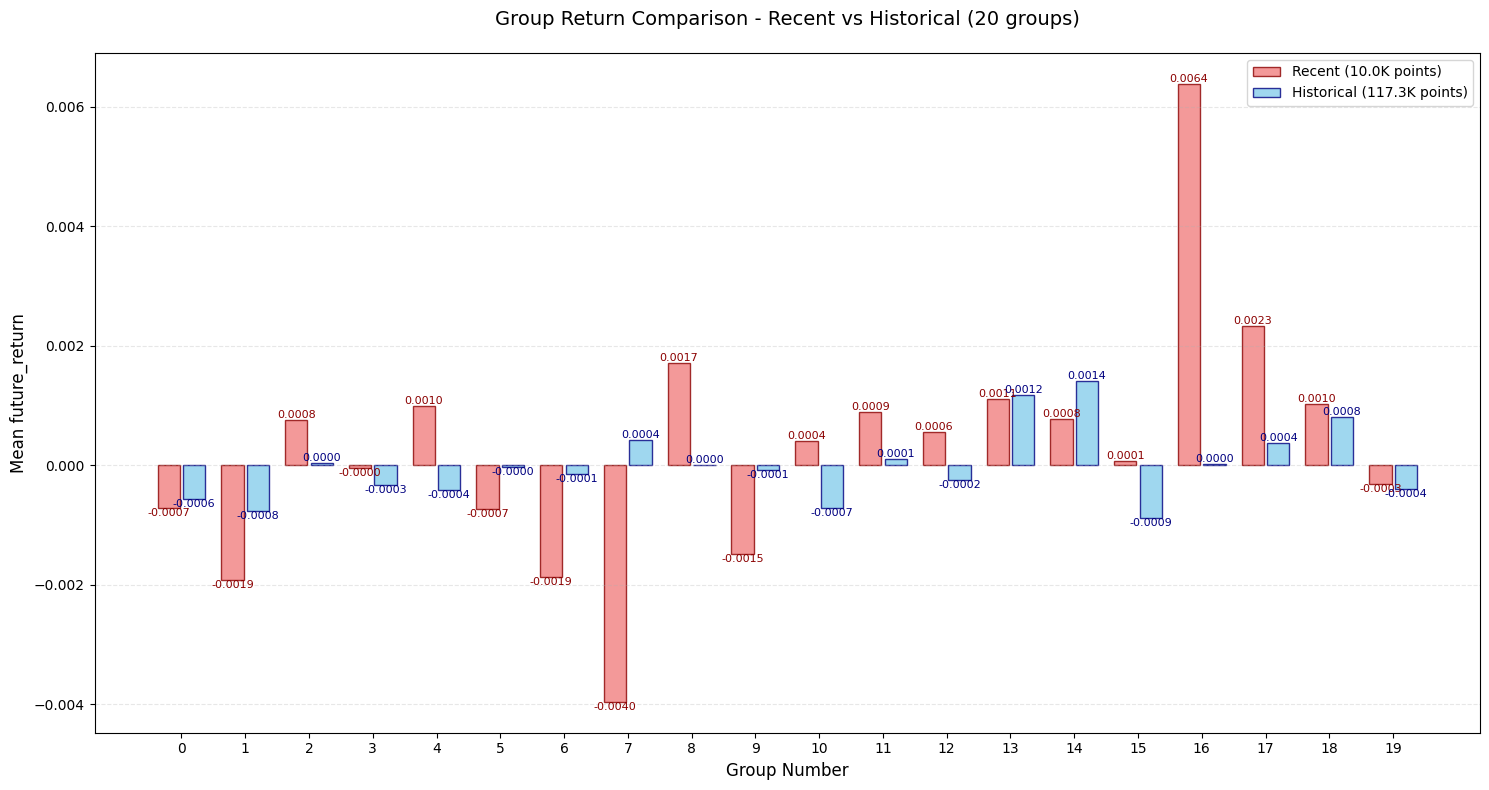

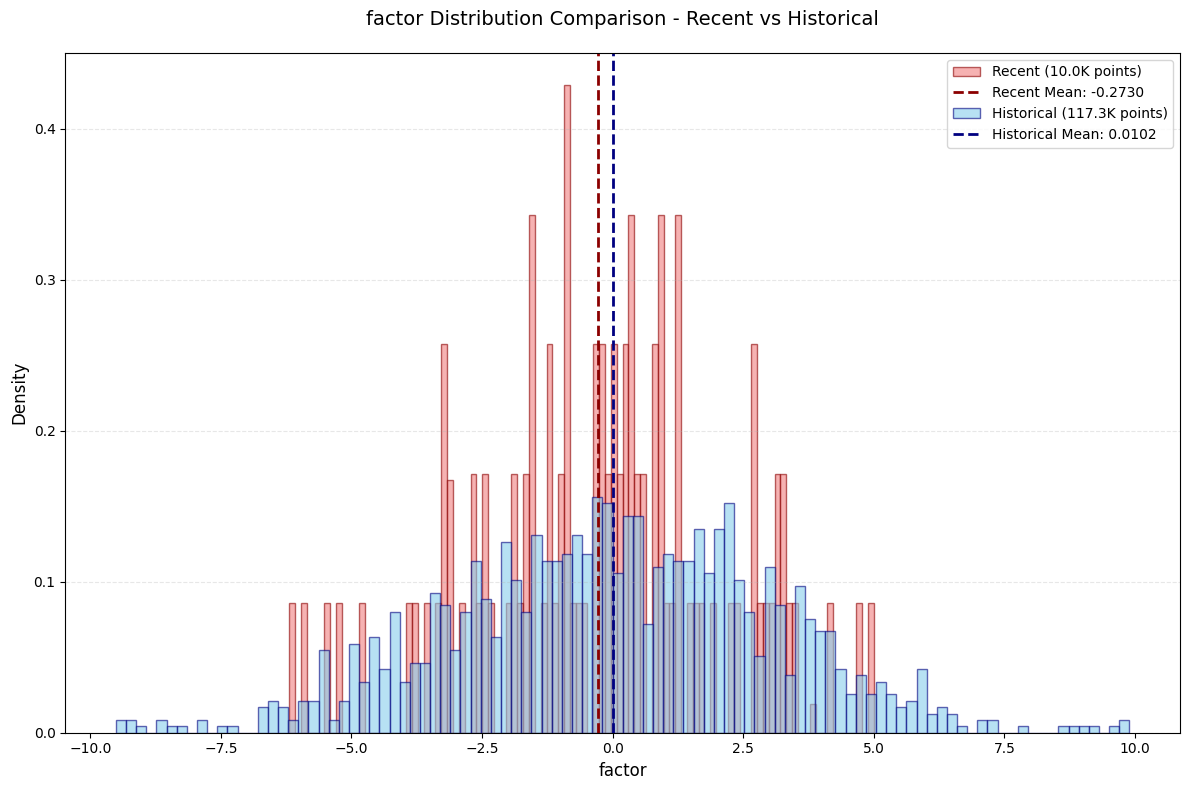

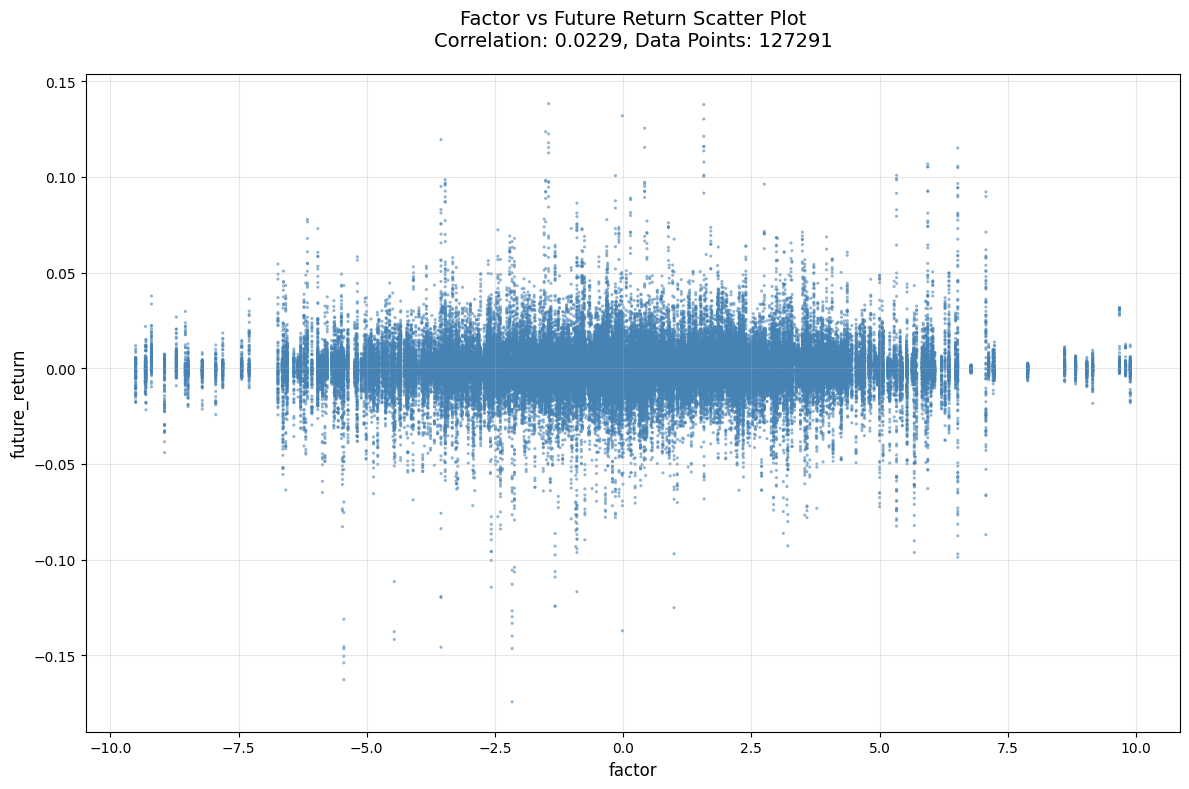

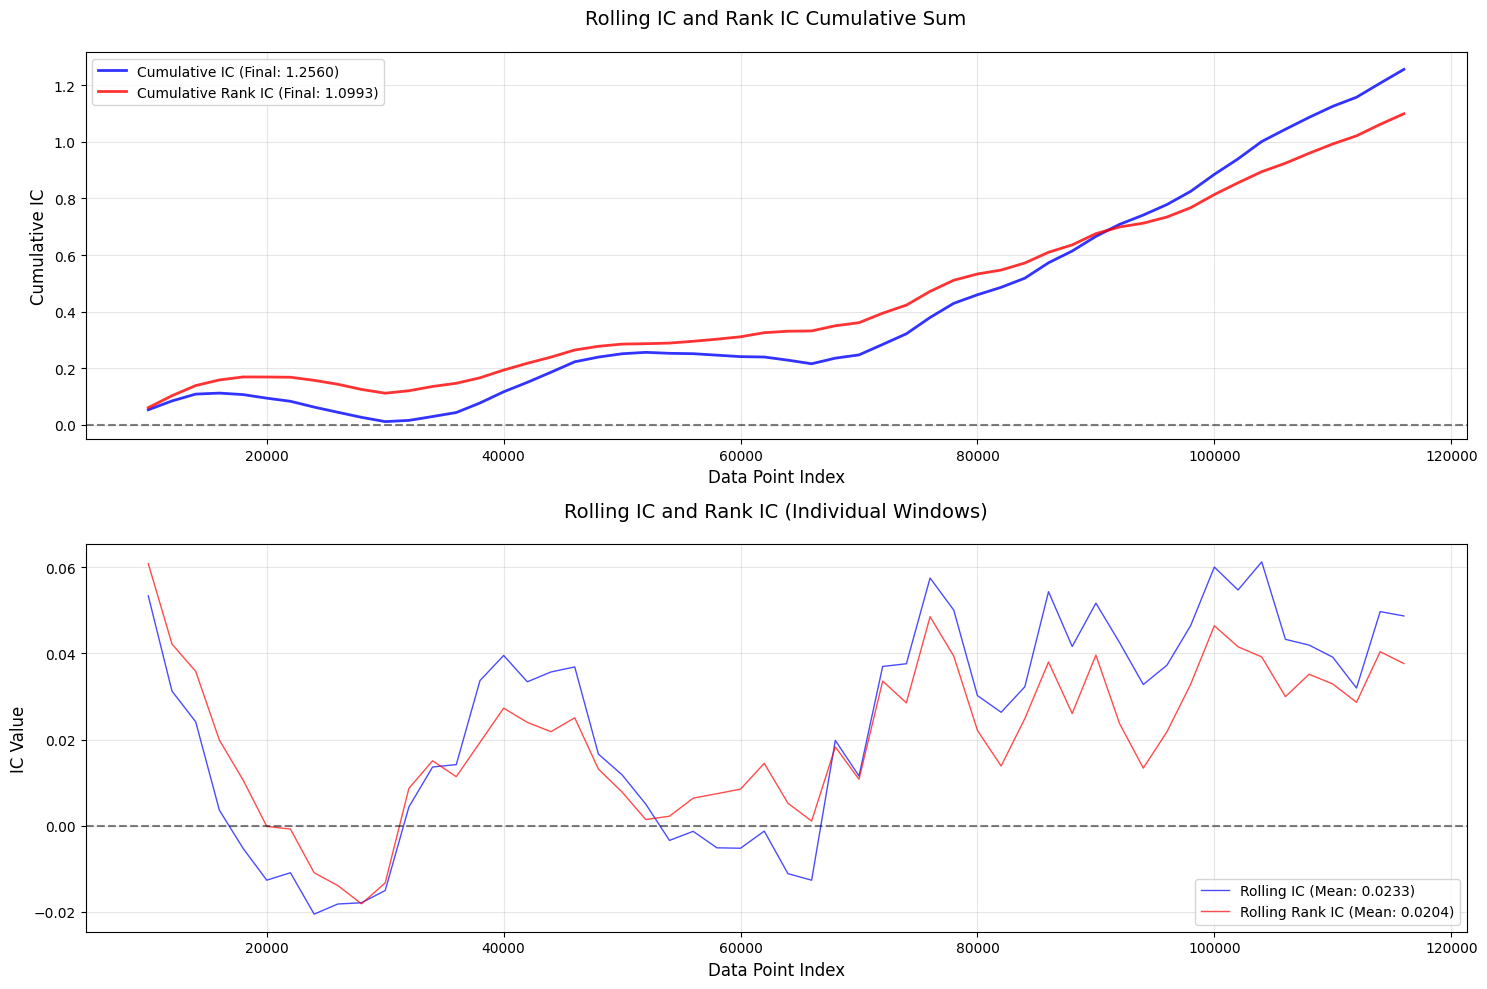

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.014659639889094427,
 0.0032056546406323857,
 0.0027027856396993795,
 0.015444427049601297,
 0.0020760178350510954,
 0.03344526525233729,
 0.0678709500949252,
 -0.0803735567989668,
 0.011126886154250856,
 -0.003980734385617236]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.022910801539497185, 'Rank_IC': 0.022124455948022884}, 'information_ratio': {'IR': 0.10357273490396296, 'group_correlations': [-0.014659639889094427, 0.0032056546406323857, 0.0027027856396993795, 0.015444427049601297, 0.0020760178350510954, 0.03344526525233729, 0.0678709500949252, -0.0803735567989668, 0.011126886154250856, -0.003980734385617236], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -9.5075  -4.9687   -6.2966      -0.0006      0.0125   6432
1      -4.9327  -3.9263   -4.4649      -0.0007      0.0104   6336
2      -3.9112  -3.2069   -3.5149      -0.0001      0.0129   6336
3      -3.1964  -2.5571   -2.8511      -0.0004      0.0109   6427
4      -2.5493  -1.9968   -2.2833      -0.0002      0.0131   6336
5      -1.9922  -1.5153   -1.7659      -0.0001      0.0104   6336
6      -1.5142  -1.1220   -1.3253      